## Model Preparation

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from imblearn.over_sampling import SMOTE
import time

import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# set random seed for reproducibility
SEED = 2025
np.random.seed(SEED)

def prepare_modelling_data(df: pd.DataFrame, target: str = 'target') -> Tuple:
    """
    prepare data for model training with proper encoding and splitting
    
    args:
        df: preprocessed dataframe
        target: target variable name
        
    returns:
        tuple of (X_train, X_val, X_test, y_train, y_val, y_test, feature_names, encoders)
    """
    df_model_prep = df.copy()
    
    # separate features and target
    if target not in df_model_prep.columns:
        raise ValueError(f"target column '{target}' not found in dataframe")
    
    y = df_model_prep[target]
    X = df_model_prep.drop(columns=[target])
    
    # encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        encoders[col] = le
    
    # convert datetime columns to numeric
    datetime_cols = X.select_dtypes(include=['datetime64']).columns.tolist()
    for col in datetime_cols:
        X[f'{col}_year'] = X[col].dt.year
        X[f'{col}_month'] = X[col].dt.month
        X = X.drop(columns=[col])
    
    feature_names = X.columns.tolist()
    
    # Set your upper and lower bounds
    lower_bound = -1e6
    upper_bound = 1e6

    # Apply across all numeric columns
    X = X.clip(lower=lower_bound, upper=upper_bound)
    
    # split data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
    )
    
    print(f"train set: {len(X_train):,} samples")
    print(f"validation set: {len(X_val):,} samples")
    print(f"test set: {len(X_test):,} samples")
    print(f"features: {len(feature_names)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_names, encoders

# load data
df_model_processed = pd.read_csv("/Users/chenjing/Desktop/credit-risk-prediction/data/processed/accepted_loans_model_ready.csv")


# prepare data
X_train, X_val, X_test, y_train, y_val, y_test, feature_names, encoders = prepare_modelling_data(
    df_model_processed
)

train set: 211,610 samples
validation set: 45,345 samples
test set: 45,346 samples
features: 26


## Model 1: Logistic Regression

LOGISTIC REGRESSION

applying SMOTE for class balance...
balanced training set: 333,404 samples

training logistic regression...
training completed in 1.67 seconds

----------------------------------------------------------------------
TRAINING SET PERFORMANCE
----------------------------------------------------------------------
accuracy............ 0.7091
precision........... 0.7158
recall.............. 0.6935
f1.................. 0.7045
roc_auc............. 0.7811

----------------------------------------------------------------------
VALIDATION SET PERFORMANCE
----------------------------------------------------------------------
accuracy............ 0.6775
precision........... 0.3257
recall.............. 0.4855
f1.................. 0.3899
roc_auc............. 0.6572

----------------------------------------------------------------------
CONFUSION MATRIX (Validation)
----------------------------------------------------------------------
true negatives:    26,051
false positives:   

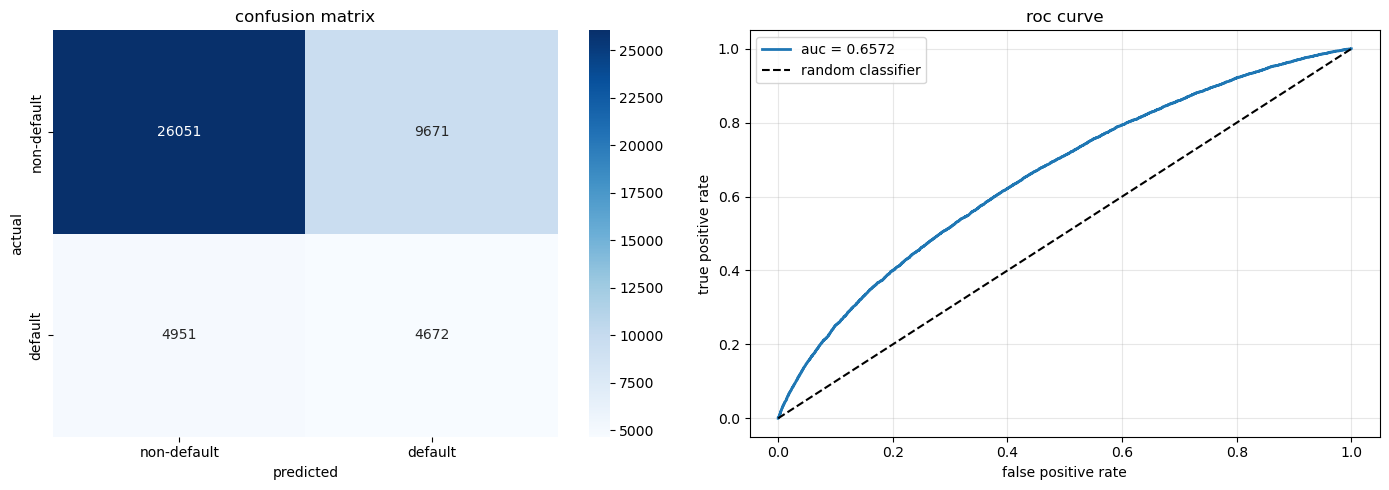

In [17]:
def train_logistic_regression(X_train, y_train, X_val, y_val, use_smote: bool = True):
    """
    train and evaluate logistic regression model
    
    args:
        X_train: training features
        y_train: training target
        X_val: validation features
        y_val: validation target
        use_smote: whether to apply SMOTE for class balance
        
    returns:
        trained model, scaler, predictions, metrics
    """
    print("=" * 70)
    print("LOGISTIC REGRESSION")
    print("=" * 70)
    
    # handle class imbalance with SMOTE if requested
    if use_smote:
        print("\napplying SMOTE for class balance...")
        smote = SMOTE(random_state=SEED)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        print(f"balanced training set: {len(X_train_balanced):,} samples")
    else:
        X_train_balanced = X_train
        y_train_balanced = y_train
    
    # scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val)
    
    # train model
    print("\ntraining logistic regression...")
    start_time = time.time()
    
    model = LogisticRegression(
        max_iter=1000,
        random_state=SEED,
        class_weight='balanced',
        solver='lbfgs',
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train_balanced)
    
    training_time = time.time() - start_time
    print(f"training completed in {training_time:.2f} seconds")
    
    # predictions
    y_train_pred = model.predict(X_train_scaled)
    y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    
    y_val_pred = model.predict(X_val_scaled)
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # evaluation
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train_balanced, y_train_pred),
            'precision': precision_score(y_train_balanced, y_train_pred),
            'recall': recall_score(y_train_balanced, y_train_pred),
            'f1': f1_score(y_train_balanced, y_train_pred),
            'roc_auc': roc_auc_score(y_train_balanced, y_train_pred_proba)
        },
        'validation': {
            'accuracy': accuracy_score(y_val, y_val_pred),
            'precision': precision_score(y_val, y_val_pred),
            'recall': recall_score(y_val, y_val_pred),
            'f1': f1_score(y_val, y_val_pred),
            'roc_auc': roc_auc_score(y_val, y_val_pred_proba)
        }
    }
    
    # print results
    print("\n" + "-" * 70)
    print("TRAINING SET PERFORMANCE")
    print("-" * 70)
    for metric, value in metrics['train'].items():
        print(f"{metric:.<20} {value:.4f}")
    
    print("\n" + "-" * 70)
    print("VALIDATION SET PERFORMANCE")
    print("-" * 70)
    for metric, value in metrics['validation'].items():
        print(f"{metric:.<20} {value:.4f}")
    
    # confusion matrix
    print("\n" + "-" * 70)
    print("CONFUSION MATRIX (Validation)")
    print("-" * 70)
    cm = confusion_matrix(y_val, y_val_pred)
    print(f"true negatives:  {cm[0, 0]:>8,}")
    print(f"false positives: {cm[0, 1]:>8,}")
    print(f"false negatives: {cm[1, 0]:>8,}")
    print(f"true positives:  {cm[1, 1]:>8,}")
    
    # visualise confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('confusion matrix')
    axes[0].set_xlabel('predicted')
    axes[0].set_ylabel('actual')
    axes[0].set_xticklabels(['non-default', 'default'])
    axes[0].set_yticklabels(['non-default', 'default'])
    
    # roc curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    axes[1].plot(fpr, tpr, label=f"auc = {metrics['validation']['roc_auc']:.4f}", linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='random classifier')
    axes[1].set_xlabel('false positive rate')
    axes[1].set_ylabel('true positive rate')
    axes[1].set_title('roc curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler, y_val_pred_proba, metrics

# train logistic regression
lr_model, lr_scaler, lr_pred_proba, lr_metrics = train_logistic_regression(
    X_train, y_train, X_val, y_val, use_smote=True
)

## Feature Importance Analysis


top 20 most important features:
                feature  coefficient  abs_coefficient
4                 grade    -2.126519         2.126519
5             sub_grade     1.684791         1.684791
2        int_rate_clean     0.954662         0.954662
16  initial_list_status    -0.389940         0.389940
20           issue_year     0.365178         0.365178
1           term_months     0.296369         0.296369
9   verification_status    -0.248602         0.248602
18             mort_acc    -0.163959         0.163959
10                  dti     0.159636         0.159636
17     application_type    -0.147544         0.147544
0             loan_amnt     0.143987         0.143987
11             open_acc     0.116839         0.116839
8            annual_inc    -0.089904         0.089904
13            revol_bal    -0.086039         0.086039
15            total_acc    -0.073370         0.073370
14     revol_util_clean     0.073028         0.073028
12              pub_rec     0.059093         0.05

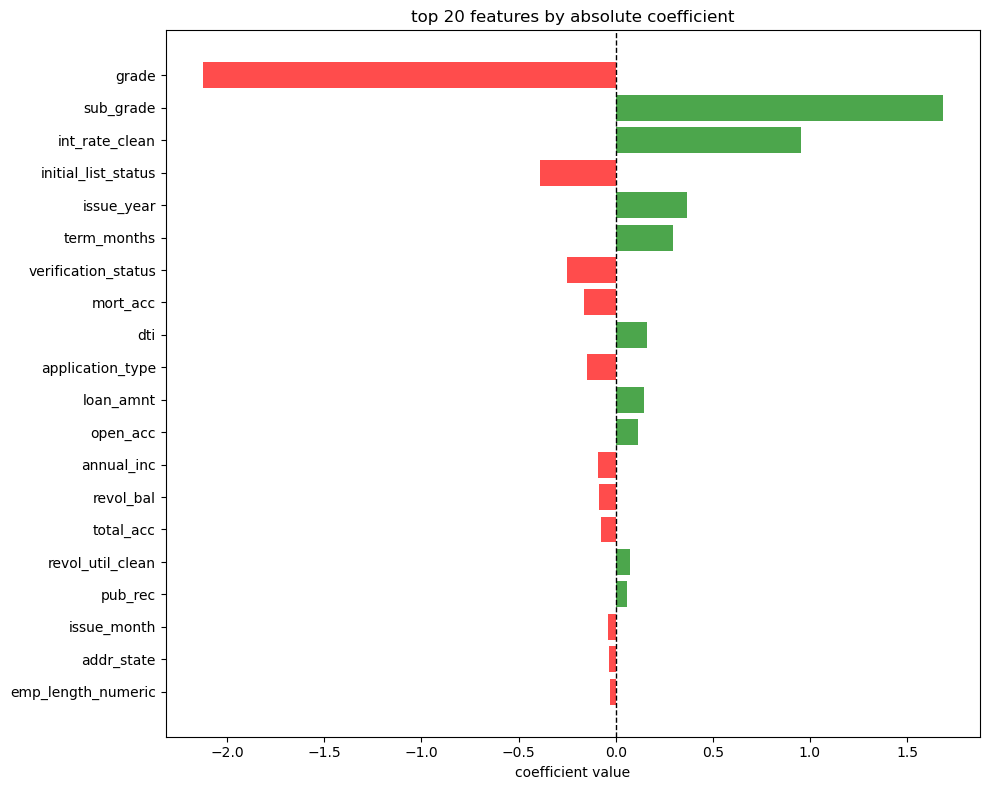

In [18]:
def analyse_logistic_regression_coefficients(model, feature_names, top_n: int = 20):
    """
    analyse and visualise logistic regression coefficients
    
    args:
        model: trained logistic regression model
        feature_names: list of feature names
        top_n: number of top features to display
    """
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\ntop 20 most important features:")
    print(coefficients.head(20))
    
    # visualise top features
    top_features = coefficients.head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
    ax.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('coefficient value')
    ax.set_title(f'top {top_n} features by absolute coefficient')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

analyse_logistic_regression_coefficients(lr_model, feature_names)

## Model 2: Random Forest
Random forest handles non-linear relationships and feature interactions without extensive preprocessing. It provides feature importance scores and is robust to outliers.

RANDOM FOREST

training random forest...
training completed in 4.33 seconds

----------------------------------------------------------------------
TRAINING SET PERFORMANCE
----------------------------------------------------------------------
accuracy............ 0.6772
precision........... 0.3639
recall.............. 0.6968
f1.................. 0.4781
roc_auc............. 0.7510

----------------------------------------------------------------------
VALIDATION SET PERFORMANCE
----------------------------------------------------------------------
accuracy............ 0.6580
precision........... 0.3406
recall.............. 0.6534
f1.................. 0.4478
roc_auc............. 0.7171

----------------------------------------------------------------------
CONFUSION MATRIX (Validation)
----------------------------------------------------------------------
true negatives:    23,549
false positives:   12,173
false negatives:    3,335
true positives:     6,288


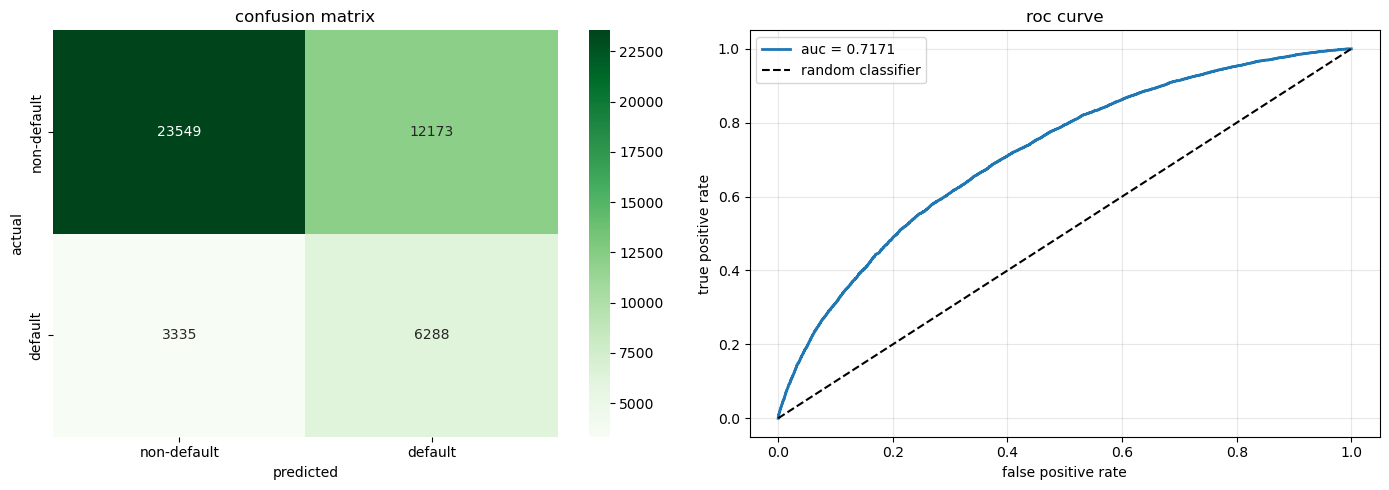

In [19]:
def train_random_forest(X_train, y_train, X_val, y_val, use_smote: bool = False):
    """
    train and evaluate random forest classifier
    
    args:
        X_train: training features
        y_train: training target
        X_val: validation features
        y_val: validation target
        use_smote: whether to apply SMOTE (not typically needed for RF)
        
    returns:
        trained model, predictions, metrics
    """
    print("=" * 70)
    print("RANDOM FOREST")
    print("=" * 70)
    
    # handle class imbalance with SMOTE if requested
    if use_smote:
        print("\napplying SMOTE for class balance...")
        smote = SMOTE(random_state=SEED)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        print(f"balanced training set: {len(X_train_balanced):,} samples")
    else:
        X_train_balanced = X_train
        y_train_balanced = y_train
    
    # train model
    print("\ntraining random forest...")
    start_time = time.time()
    
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1,
        verbose=0
    )
    model.fit(X_train_balanced, y_train_balanced)
    
    training_time = time.time() - start_time
    print(f"training completed in {training_time:.2f} seconds")
    
    # predictions
    y_train_pred = model.predict(X_train_balanced)
    y_train_pred_proba = model.predict_proba(X_train_balanced)[:, 1]
    
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # evaluation
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train_balanced, y_train_pred),
            'precision': precision_score(y_train_balanced, y_train_pred),
            'recall': recall_score(y_train_balanced, y_train_pred),
            'f1': f1_score(y_train_balanced, y_train_pred),
            'roc_auc': roc_auc_score(y_train_balanced, y_train_pred_proba)
        },
        'validation': {
            'accuracy': accuracy_score(y_val, y_val_pred),
            'precision': precision_score(y_val, y_val_pred),
            'recall': recall_score(y_val, y_val_pred),
            'f1': f1_score(y_val, y_val_pred),
            'roc_auc': roc_auc_score(y_val, y_val_pred_proba)
        }
    }
    
    # print results
    print("\n" + "-" * 70)
    print("TRAINING SET PERFORMANCE")
    print("-" * 70)
    for metric, value in metrics['train'].items():
        print(f"{metric:.<20} {value:.4f}")
    
    print("\n" + "-" * 70)
    print("VALIDATION SET PERFORMANCE")
    print("-" * 70)
    for metric, value in metrics['validation'].items():
        print(f"{metric:.<20} {value:.4f}")
    
    # confusion matrix
    print("\n" + "-" * 70)
    print("CONFUSION MATRIX (Validation)")
    print("-" * 70)
    cm = confusion_matrix(y_val, y_val_pred)
    print(f"true negatives:  {cm[0, 0]:>8,}")
    print(f"false positives: {cm[0, 1]:>8,}")
    print(f"false negatives: {cm[1, 0]:>8,}")
    print(f"true positives:  {cm[1, 1]:>8,}")
    
    # visualise confusion matrix and roc curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
    axes[0].set_title('confusion matrix')
    axes[0].set_xlabel('predicted')
    axes[0].set_ylabel('actual')
    axes[0].set_xticklabels(['non-default', 'default'])
    axes[0].set_yticklabels(['non-default', 'default'])
    
    # roc curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    axes[1].plot(fpr, tpr, label=f"auc = {metrics['validation']['roc_auc']:.4f}", linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='random classifier')
    axes[1].set_xlabel('false positive rate')
    axes[1].set_ylabel('true positive rate')
    axes[1].set_title('roc curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, y_val_pred_proba, metrics

# train random forest
rf_model, rf_pred_proba, rf_metrics = train_random_forest(
    X_train, y_train, X_val, y_val, use_smote=False
)

## Feature Importance Analysis


top 20 most important features:
                 feature  importance
5              sub_grade    0.189300
4                  grade    0.169975
2         int_rate_clean    0.166812
1            term_months    0.077528
20            issue_year    0.056761
23  loan_to_income_ratio    0.054012
10                   dti    0.043608
18              mort_acc    0.025290
3            installment    0.024868
8             annual_inc    0.023358
13             revol_bal    0.022712
0              loan_amnt    0.020477
14      revol_util_clean    0.018307
22  credit_history_years    0.017068
7         home_ownership    0.013369
11              open_acc    0.012921
15             total_acc    0.012313
25            addr_state    0.011553
9    verification_status    0.009792
21           issue_month    0.008626


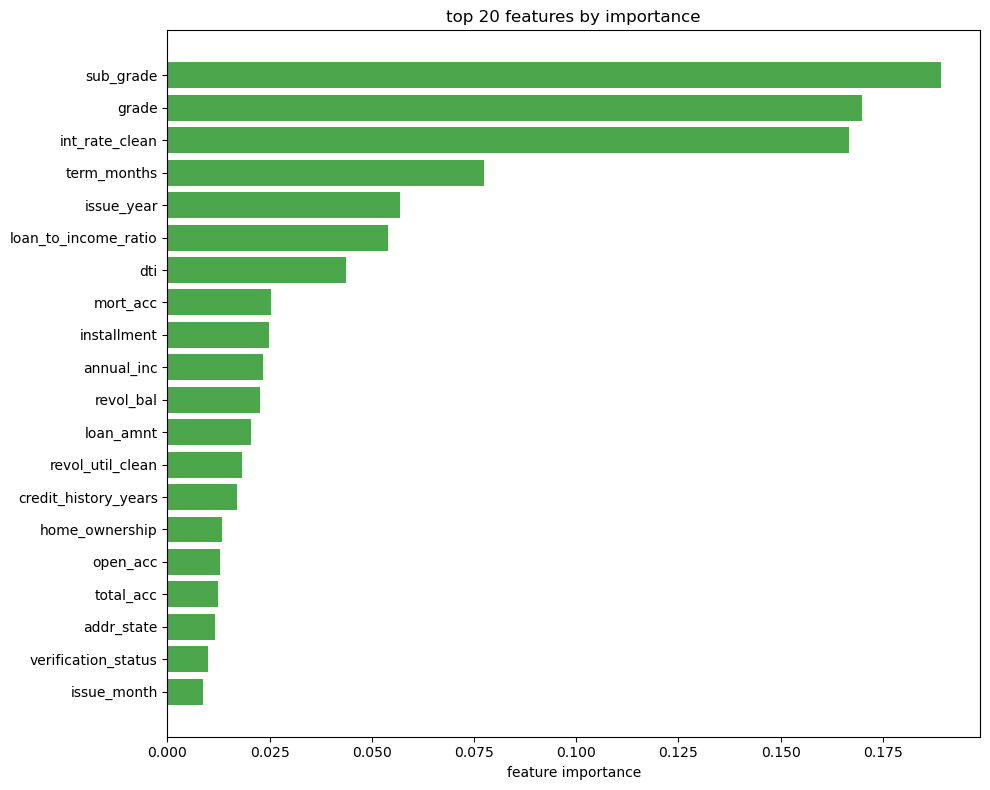

In [20]:
def analyse_random_forest_importance(model, feature_names, top_n: int = 20):
    """
    analyse and visualise random forest feature importance
    
    args:
        model: trained random forest model
        feature_names: list of feature names
        top_n: number of top features to display
    """
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\ntop {top_n} most important features:")
    print(importance.head(top_n))
    
    # visualise top features
    top_features = importance.head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_features)), top_features['importance'], color='green', alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('feature importance')
    ax.set_title(f'top {top_n} features by importance')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return importance

rf_importance = analyse_random_forest_importance(rf_model, feature_names)

## Model 3: XGBoost
XGBoost typically provides best performance for tabular data through gradient boosting. It handles missing values internally and provides regularisation to prevent overfitting.

XGBOOST

scale_pos_weight: 3.71

training xgboost...
training completed in 0.83 seconds

----------------------------------------------------------------------
TRAINING SET PERFORMANCE
----------------------------------------------------------------------
accuracy............ 0.6750
precision........... 0.3634
recall.............. 0.7065
f1.................. 0.4799
roc_auc............. 0.7552

----------------------------------------------------------------------
VALIDATION SET PERFORMANCE
----------------------------------------------------------------------
accuracy............ 0.6586
precision........... 0.3435
recall.............. 0.6684
f1.................. 0.4538
roc_auc............. 0.7243

----------------------------------------------------------------------
CONFUSION MATRIX (Validation)
----------------------------------------------------------------------
true negatives:    23,431
false positives:   12,291
false negatives:    3,191
true positives:     6,432


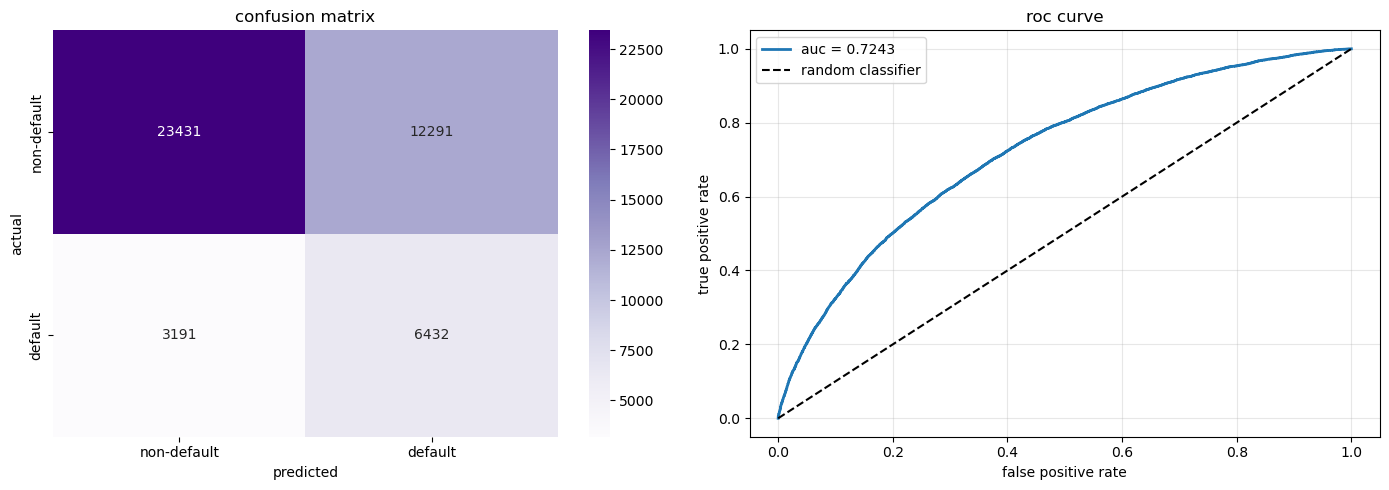

In [23]:
def train_xgboost(X_train, y_train, X_val, y_val, use_smote: bool = False):
    """
    train and evaluate xgboost classifier
    
    args:
        X_train: training features
        y_train: training target
        X_val: validation features
        y_val: validation target
        use_smote: whether to apply SMOTE
        
    returns:
        trained model, predictions, metrics
    """
    print("=" * 70)
    print("XGBOOST")
    print("=" * 70)
    
    # calculate scale_pos_weight for class imbalance
    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")
    
    # handle class imbalance with SMOTE if requested
    if use_smote:
        print("\napplying SMOTE for class balance...")
        smote = SMOTE(random_state=SEED)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        print(f"balanced training set: {len(X_train_balanced):,} samples")
        scale_pos_weight = 1  # no need when using SMOTE
    else:
        X_train_balanced = X_train
        y_train_balanced = y_train
    
    # train model
    print("\ntraining xgboost...")
    start_time = time.time()
    
    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=SEED,
        n_jobs=-1,
        eval_metric='logloss'
    )
    model.fit(
        X_train_balanced, y_train_balanced,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    training_time = time.time() - start_time
    print(f"training completed in {training_time:.2f} seconds")
    
    # predictions
    y_train_pred = model.predict(X_train_balanced)
    y_train_pred_proba = model.predict_proba(X_train_balanced)[:, 1]
    
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # evaluation
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train_balanced, y_train_pred),
            'precision': precision_score(y_train_balanced, y_train_pred),
            'recall': recall_score(y_train_balanced, y_train_pred),
            'f1': f1_score(y_train_balanced, y_train_pred),
            'roc_auc': roc_auc_score(y_train_balanced, y_train_pred_proba)
        },
        'validation': {
            'accuracy': accuracy_score(y_val, y_val_pred),
            'precision': precision_score(y_val, y_val_pred),
            'recall': recall_score(y_val, y_val_pred),
            'f1': f1_score(y_val, y_val_pred),
            'roc_auc': roc_auc_score(y_val, y_val_pred_proba)
        }
    }
    
    # print results
    print("\n" + "-" * 70)
    print("TRAINING SET PERFORMANCE")
    print("-" * 70)
    for metric, value in metrics['train'].items():
        print(f"{metric:.<20} {value:.4f}")
    
    print("\n" + "-" * 70)
    print("VALIDATION SET PERFORMANCE")
    print("-" * 70)
    for metric, value in metrics['validation'].items():
        print(f"{metric:.<20} {value:.4f}")
    
    # confusion matrix
    print("\n" + "-" * 70)
    print("CONFUSION MATRIX (Validation)")
    print("-" * 70)
    cm = confusion_matrix(y_val, y_val_pred)
    print(f"true negatives:  {cm[0, 0]:>8,}")
    print(f"false positives: {cm[0, 1]:>8,}")
    print(f"false negatives: {cm[1, 0]:>8,}")
    print(f"true positives:  {cm[1, 1]:>8,}")
    
    # visualise confusion matrix and roc curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0])
    axes[0].set_title('confusion matrix')
    axes[0].set_xlabel('predicted')
    axes[0].set_ylabel('actual')
    axes[0].set_xticklabels(['non-default', 'default'])
    axes[0].set_yticklabels(['non-default', 'default'])
    
    # roc curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    axes[1].plot(fpr, tpr, label=f"auc = {metrics['validation']['roc_auc']:.4f}", linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='random classifier')
    axes[1].set_xlabel('false positive rate')
    axes[1].set_ylabel('true positive rate')
    axes[1].set_title('roc curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, y_val_pred_proba, metrics

# train xgboost
xgb_model, xgb_pred_proba, xgb_metrics = train_xgboost(
    X_train, y_train, X_val, y_val, use_smote=False
)

## Feature Importance Analysis


top 20 most important features:
                 feature  importance
4                  grade    0.581195
1            term_months    0.081467
5              sub_grade    0.075342
2         int_rate_clean    0.034929
20            issue_year    0.030531
7         home_ownership    0.018513
18              mort_acc    0.016490
23  loan_to_income_ratio    0.012963
10                   dti    0.010375
9    verification_status    0.010117
8             annual_inc    0.009276
17      application_type    0.009233
11              open_acc    0.008761
6     emp_length_numeric    0.008734
25            addr_state    0.008698
3            installment    0.008696
21           issue_month    0.008258
19  pub_rec_bankruptcies    0.008093
24               purpose    0.007990
0              loan_amnt    0.007864


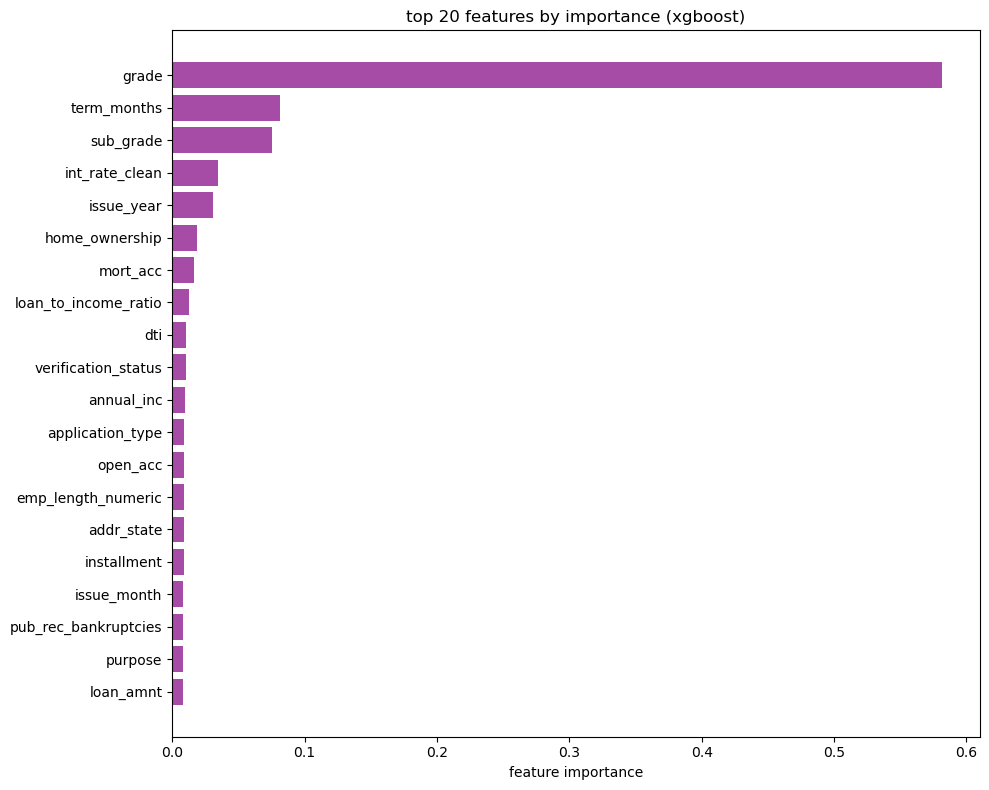

In [24]:
def analyse_xgboost_importance(model, feature_names, top_n: int = 20):
    """
    analyse and visualise xgboost feature importance
    
    args:
        model: trained xgboost model
        feature_names: list of feature names
        top_n: number of top features to display
    """
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\ntop {top_n} most important features:")
    print(importance.head(top_n))
    
    # visualise top features
    top_features = importance.head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_features)), top_features['importance'], color='purple', alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('feature importance')
    ax.set_title(f'top {top_n} features by importance (xgboost)')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return importance

xgb_importance = analyse_xgboost_importance(xgb_model, feature_names)

## Model Comparison

MODEL COMPARISON (Validation Set)
                     accuracy  precision  recall      f1  roc_auc
logistic_regression    0.6775     0.3257  0.4855  0.3899   0.6572
random_forest          0.6580     0.3406  0.6534  0.4478   0.7171
xgboost                0.6586     0.3435  0.6684  0.4538   0.7243


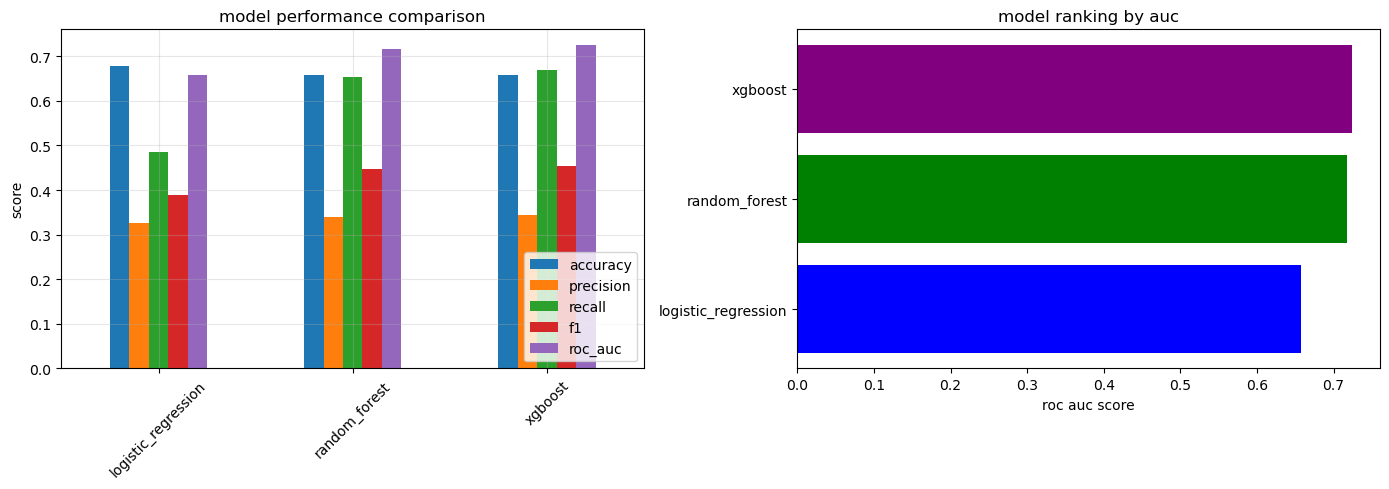


best model: xgboost
best auc: 0.7243


In [25]:
def compare_models(lr_metrics, rf_metrics, xgb_metrics):
    """
    compare performance across all models
    
    args:
        lr_metrics: logistic regression metrics dict
        rf_metrics: random forest metrics dict
        xgb_metrics: xgboost metrics dict
    """
    comparison = pd.DataFrame({
        'logistic_regression': lr_metrics['validation'],
        'random_forest': rf_metrics['validation'],
        'xgboost': xgb_metrics['validation']
    }).T
    
    print("=" * 70)
    print("MODEL COMPARISON (Validation Set)")
    print("=" * 70)
    print(comparison.round(4))
    
    # visualise comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # bar chart comparison
    comparison.plot(kind='bar', ax=axes[0], rot=45)
    axes[0].set_title('model performance comparison')
    axes[0].set_ylabel('score')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # roc auc comparison
    auc_scores = comparison['roc_auc'].sort_values(ascending=False)
    axes[1].barh(range(len(auc_scores)), auc_scores.values, color=['purple', 'green', 'blue'])
    axes[1].set_yticks(range(len(auc_scores)))
    axes[1].set_yticklabels(auc_scores.index)
    axes[1].set_xlabel('roc auc score')
    axes[1].set_title('model ranking by auc')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # identify best model
    best_model = comparison['roc_auc'].idxmax()
    best_auc = comparison['roc_auc'].max()
    
    print(f"\nbest model: {best_model}")
    print(f"best auc: {best_auc:.4f}")
    
    return comparison

model_comparison = compare_models(lr_metrics, rf_metrics, xgb_metrics)